# Helper Functions

In [1]:
def get_pdf(data):
    from scipy.stats.kde import gaussian_kde
    from numpy import linspace
    
    kde = gaussian_kde(data)

    return kde    

In [2]:
def plot_pdf(data, label='', x_axis=''):
    from scipy.stats.kde import gaussian_kde
    from numpy import linspace
    
    # create two subplots
    fig, axs = plt.subplots(1, 2)
    fig.suptitle("Probability Distribution and Historgram "+label)
    
    #create the kernel, which estimates the probability over the values in the array
    kde = gaussian_kde(data)
    
    #these are the values over wich your kernel will be evaluated
    dist_space = linspace(min(data),max(data), 100)

    # plot the results
    axs[0].plot(dist_space, kde(dist_space))
    axs[0].set_ylabel('probability')
    axs[0].set_xlabel(x_axis)
    axs[1].hist(data)
    axs[1].set_ylabel('histogram')
    axs[1].set_xlabel('x_axis')
    plt.show()

In [3]:
def get_dist(df, var='age', bucket_size=5, to_print=False):
    import math
    
    # create an array that holds the counts of different age groups in bucket_size 
    arr = [];
    for x in range(0,100,bucket_size):
        arr.append(0)
    
    # go through the data, look at each age and update counter for that age group
    for x in df[var]:
        index = math.floor(x/bucket_size)
        arr[index] = arr[index] + 1;

    if to_print:
        age = 0;
        # print the array
        for x in arr:
            print(str(age) + "-" + str(age+bucket_size), ": ", x)
            age = age + bucket_size
    
    return arr

In [4]:
def find_new_len(len_df_one, dist_one, len_df_two, dist_two):
    import math 
    
    new_len = len_df_one

    for precision in np.arange(1, 0, -0.05):
        new_len = len_df_one
        for i in range(len(dist_one)):
            if dist_one[i] < (new_len*dist_two[i]/len_df_two)*precision:
                if dist_one[i] != 0:
                    new_len = math.floor(dist_one[i]*len_df_two/dist_two[i])
                else:
                    new_len = new_len - (new_len*dist_two[i]/len_df_two)
        if new_len >= 50:
            print("New Length: ", new_len, " with Precision: ", precision)
            break
            
    return new_len

In [5]:
def match_dist(df_to, df_from, var='age', var_1 = 'subject', bucket_size=3):
    import math 
    
    df_new = pd.DataFrame([])
    
    # sort the dataframes
    df_to = df_to.sort_values(by=var)
    df_from = df_from.sort_values(by=var)
    
    # get the distributions from both
    dist_to = get_dist(df_to, bucket_size=bucket_size)
    dist_from = get_dist(df_from, bucket_size=bucket_size)
    
    index = 0
    i = 0
    rand_subj = []
    
    # calculate the size of the new dataset that would allow for the same distribution as the dataset being mimicked
    df_new_length = find_new_len(len(df_to), dist_to, len(df_from), dist_from)
    
    # go through the number of subjects in the age range of the resampling data
    for x in np.arange(0, 100, bucket_size):
        subj_bucket = []
        
        # get all the subjects in the age range of the resampling data
        for j in range(dist_to[i]):
            subj_bucket.append((df_to[var_1])[index+j])

        index = index + dist_to[i]
        
        # get the number of subjects in the data that is being mimicked
        num_rand = math.floor(df_new_length * (dist_from[i]/len(df_from)))
        
        if not len(subj_bucket) == 0:
            # choose random subjects from subject bucket
            # the number of random subjects chosen depends on the distributions
            rand_subj = []
            
            if dist_to[i] < num_rand:
                rand_subj = np.random.choice(subj_bucket, size=dist_to[i], replace=False)
            else:
                rand_subj = np.random.choice(subj_bucket, size=num_rand, replace=False)
        
        for sub in rand_subj:
                temp = pd.DataFrame(df_to[df_to[var_1] == sub])
                df_new = pd.concat([df_new, df_to[df_to[var_1] == sub]])

        # increment index for age distribution array
        i = i+1
    
    return df_new

In [6]:
def sample(df_to, df_from, title_to='', title_from='', var='age', var_1='subject', bucket_size=3):
    from scipy import stats

    plot_pdf(df_from[var], title_from, var)
    plot_pdf(df_to[var], title_to , var)
    
    # sample from original
    df_sample = match_dist(df_to, df_from, bucket_size = bucket_size)
    print("Actual Length: ", len(df_sample))
    print(df_sample.head())
    
    # plot new probability density function
    plot_pdf(df_sample[var], title_to + ":" + title_from, var)
    
    # test if the two distributions would be the same
    print("stats: ", stats.ks_2samp(df_sample[var], df_from[var]))
    
    return df_sample

# Hypothesis #1

Research Question:
If the distribution of ages in training and test sets is causing the poor generalizability of both complex and simple models, then both simple and complex models trained on datasets with similar age distributions to our original training dataset will perform worse than chance when tested on samples from new datasets that mimic the age distribution of our original test dataset.

## Setup

In [7]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [8]:
# project directory
project_dir = Path('/data/NNDSP')

# NNDSP data directories
nndsp_bids_dir = Path('/data/NNDSP/bids_2017_07_14_generic')
nndsp_fs_dir = Path('/data/NNDSP/derivatives/fs5.3_subj')
nndsp_bar_dir = Path('/data/NNDSP/derivatives/bar_subj')
nndsp_pheno_file = Path('/data/NNDSP/anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv')

# HCP data directories
hcp_bids_dir = Path('/data/HCP/HCP_900/s3/hcp')
hcp_fs_dir = Path('/data/NNDSP/derivatives/fs_hcp_subj')
hcp_bar_dir = Path('/data/NNDSP/derivatives/bar_hcp_subj')
hcp_pheno_file = Path('/data/NNDSP/nino/HCP_ages.csv')

# NKI data directories
nki_bids_dir = Path('/data/NNDSP/anal/NKI')
nki_fs_dir = Path('/data/NNDSP/derivatives/fs_nki_subj')
hcp_bar_dir = Path('/data/NNDSP/derivatives/bar_nki_subj')
nki_pheno_file = Path('/data/NNDSP/anal/analysis_notebooks/phenotype_files/participants.tsv')

# CoRR data directories
corr_bids_dir = Path('/data/DSST/CoRR/bids_corr')
corr_fs_dir = Path('/data/DSST/CoRR/fs_corr')
corr_pheno_file = Path('/data/DSST/CoRR/phenotype_files/corr_ages.csv')

# SALD data directories
sald_bids_dir = Path('/data/DSST/SALD/bids_sald')
# sald_fs_dir = Path('/data/NNDSP/derivatives/fs5.3_subj')
sald_pheno_file = Path('/data/DSST/SALD/phenotype_files/sub_information.xlsx')

## NNDSP Subject Data

In [9]:
# merge the subjects that we have fs and add subject number
df_nndsp = pd.DataFrame({'subj_paths' : [x.as_posix() for x in nndsp_fs_dir.glob('sub-*')]})
df_nndsp = df_nndsp.assign(MASKID = [int(Path(x).name[4:]) for x in df_nndsp.subj_paths])
df_nndsp.head()

,subj_paths,MASKID
0,/data/NNDSP/derivatives/fs5.3_subj/sub-1889,1889
1,/data/NNDSP/derivatives/fs5.3_subj/sub-2011,2011
2,/data/NNDSP/derivatives/fs5.3_subj/sub-1948,1948
3,/data/NNDSP/derivatives/fs5.3_subj/sub-1198,1198
4,/data/NNDSP/derivatives/fs5.3_subj/sub-1371,1371


In [10]:
# merge the subjects we have fs of with their ages
df_nndsp = pd.merge(df_nndsp, pd.read_csv(nndsp_pheno_file.as_posix()), on='MASKID')

In [11]:
# rename columns so that we have standardization across datasets
df_nndsp = df_nndsp.rename(index=str, columns = {'MASKID' : 'subject', 'age_at_scan' : 'age'})
df_nndsp = df_nndsp.drop_duplicates(subset='subject', keep='first')
df_nndsp.head()

,subj_paths,subject,MRN,nuclear_fam_id,Sex,age
0,/data/NNDSP/derivatives/fs5.3_subj/sub-1889,1889,7135075,10230,Female,9.667351
1,/data/NNDSP/derivatives/fs5.3_subj/sub-2011,2011,7078997,10109,Male,18.310746
2,/data/NNDSP/derivatives/fs5.3_subj/sub-1948,1948,4571265,1854,Female,14.269678
3,/data/NNDSP/derivatives/fs5.3_subj/sub-1198,1198,4359628,1613,Male,14.390144
4,/data/NNDSP/derivatives/fs5.3_subj/sub-1371,1371,7218874,10286,Male,16.621492


## HCP Subject Data

In [12]:
# merge the subjects that we have fs and add subject number
df_hcp = pd.DataFrame({'subj_paths' : [x.as_posix() for x in hcp_fs_dir.glob('sub-*')]})
df_hcp = df_hcp.assign(Subject = [int(Path(x).name[4:]) for x in df_hcp.subj_paths])
df_hcp.head()

,subj_paths,Subject
0,/data/NNDSP/derivatives/fs_hcp_subj/sub-749361,749361
1,/data/NNDSP/derivatives/fs_hcp_subj/sub-191942,191942
2,/data/NNDSP/derivatives/fs_hcp_subj/sub-983773,983773
3,/data/NNDSP/derivatives/fs_hcp_subj/sub-387959,387959
4,/data/NNDSP/derivatives/fs_hcp_subj/sub-193441,193441


In [13]:
# merge the subjects we have fs of with their ages
df_hcp = pd.merge(df_hcp, pd.read_csv(hcp_pheno_file.as_posix()), on='Subject')

In [14]:
# rename columns so that we have standardization across datasets
df_hcp = df_hcp.rename(index=str, columns={'Subject' : 'subject', 'Age_in_Yrs' : 'age'})
df_hcp = df_hcp.drop_duplicates(subset='subject', keep='first')
df_hcp.head()

,subj_paths,subject,age,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,...,SSAGA_Times_Used_Illicits,SSAGA_Times_Used_Cocaine,SSAGA_Times_Used_Hallucinogens,SSAGA_Times_Used_Opiates,SSAGA_Times_Used_Sedatives,SSAGA_Times_Used_Stimulants,SSAGA_Mj_Use,SSAGA_Mj_Ab_Dep,SSAGA_Mj_Age_1st_Use,SSAGA_Mj_Times_Used
0,/data/NNDSP/derivatives/fs_hcp_subj/sub-749361,749361,29,True,NotTwin,,52442_82285,52442,82285,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0
1,/data/NNDSP/derivatives/fs_hcp_subj/sub-191942,191942,27,True,NotTwin,,56029_85850,56029,85850,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
2,/data/NNDSP/derivatives/fs_hcp_subj/sub-983773,983773,28,True,NotTwin,,52801_82622,52801,82622,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
3,/data/NNDSP/derivatives/fs_hcp_subj/sub-387959,387959,26,True,NotMZ,,55795_85616,55795,85616,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,2.0
4,/data/NNDSP/derivatives/fs_hcp_subj/sub-193441,193441,28,True,NotTwin,,52875_82697,52875,82697,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


## NKI Subject Data

In [15]:
# merge the subjects that we have fs and add subject number
df_nki = pd.DataFrame({'subj_paths' : [x.as_posix() for x in nki_fs_dir.glob('sub-*')]})
df_nki = df_nki.assign(participant_id = [Path(x).name[4:13] for x in df_nki.subj_paths])
df_nki.head()

,subj_paths,participant_id
0,/data/NNDSP/derivatives/fs_nki_subj/sub-A00023510,A00023510
1,/data/NNDSP/derivatives/fs_nki_subj/sub-A00066...,A00066087
2,/data/NNDSP/derivatives/fs_nki_subj/sub-A00066...,A00066236
3,/data/NNDSP/derivatives/fs_nki_subj/sub-A00034350,A00034350
4,/data/NNDSP/derivatives/fs_nki_subj/sub-A00063003,A00063003


In [16]:
# merge the subjects that we have fs with age
df_nki = pd.merge(df_nki, pd.read_csv(nki_pheno_file.as_posix(), sep='\t'), on='participant_id')

In [17]:
# rename so that we have standardization across datasets
df_nki = df_nki.rename(index=str, columns={'participant_id' : 'subject', 'age' : 'age'})
df_nki = df_nki.drop_duplicates(subset='subject', keep='first')
df_nki.head()

,subj_paths,subject,age,sex,handedness
0,/data/NNDSP/derivatives/fs_nki_subj/sub-A00023510,A00023510,23.0,MALE,RIGHT
1,/data/NNDSP/derivatives/fs_nki_subj/sub-A00066...,A00066087,22.0,MALE,RIGHT
4,/data/NNDSP/derivatives/fs_nki_subj/sub-A00066...,A00066236,33.0,MALE,RIGHT
7,/data/NNDSP/derivatives/fs_nki_subj/sub-A00034350,A00034350,11.0,MALE,RIGHT
8,/data/NNDSP/derivatives/fs_nki_subj/sub-A00063003,A00063003,13.0,MALE,RIGHT


## CoRR Subject Data

In [18]:
# merge the subjects that we have fs and add subject number
df_corr = pd.DataFrame({'subj_paths' : [x.as_posix() for x in corr_fs_dir.glob('sub-*')]})
df_corr = df_corr.assign(SUBID = [int(Path(x).name[4:11]) for x in df_corr.subj_paths])
df_corr.head()

,subj_paths,SUBID
0,/data/DSST/CoRR/fs_corr/sub-0025482,25482
1,/data/DSST/CoRR/fs_corr/sub-0003057,3057
2,/data/DSST/CoRR/fs_corr/sub-0026120_ses-2,26120
3,/data/DSST/CoRR/fs_corr/sub-0025728_ses-2.long...,25728
4,/data/DSST/CoRR/fs_corr/sub-0025052,25052


In [20]:
# merge subjects with ages 
df_corr = pd.merge(df_corr, pd.read_csv(corr_pheno_file.as_posix()), on='SUBID')

In [21]:
# rename so that we have standardization across datasets
df_corr = df_corr.rename(index=str, columns={'SUBID' : 'subject', 'AGE_AT_SCAN_1' : 'age'})
df_corr = df_corr.sort_values(by='subj_paths')
df_corr = df_corr.drop_duplicates(subset='subject', keep='first')
df_corr.age = pd.to_numeric(df_corr.age, errors='coerce').fillna(0).astype(np.int64)
df_corr.head()

,subj_paths,subject,Unnamed: 0,age,SEX
3018,/data/DSST/CoRR/fs_corr/sub-0003001,3001,0,25,2
5362,/data/DSST/CoRR/fs_corr/sub-0003002,3002,2,23,1
5529,/data/DSST/CoRR/fs_corr/sub-0003004,3004,4,31,2
5320,/data/DSST/CoRR/fs_corr/sub-0003006,3006,6,23,1
5642,/data/DSST/CoRR/fs_corr/sub-0003007,3007,8,43,2


## SALD Subject Data

In [22]:
# complete once we have SALD FS files

## Sample NKI:NNDSP

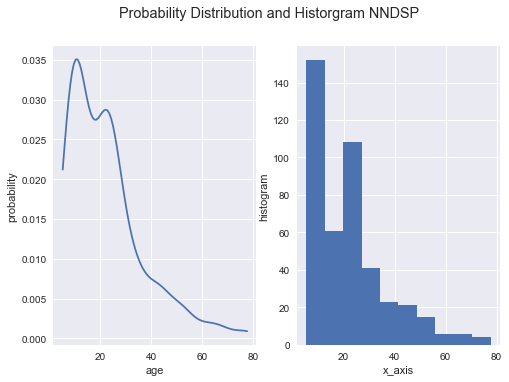

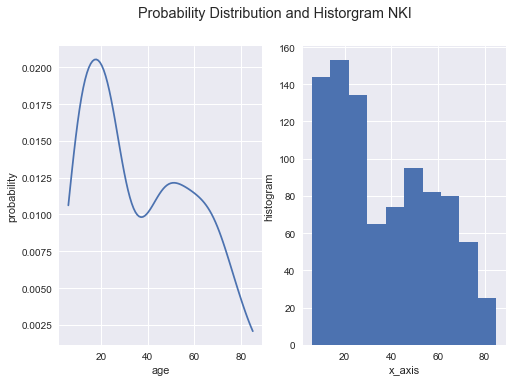

New Length:  329  with Precision:  1.0
Actual Length:  316
                                            subj_paths    subject  age  \
433  /data/NNDSP/derivatives/fs_nki_subj/sub-A00060...  A00060493  6.0   
651  /data/NNDSP/derivatives/fs_nki_subj/sub-A00056...  A00056307  8.0   
244  /data/NNDSP/derivatives/fs_nki_subj/sub-A00058...  A00058215  6.0   
182  /data/NNDSP/derivatives/fs_nki_subj/sub-A00053...  A00053171  8.0   
343  /data/NNDSP/derivatives/fs_nki_subj/sub-A00058060  A00058060  8.0   

        sex     handedness  
433  FEMALE          RIGHT  
651  FEMALE          RIGHT  
244  FEMALE          RIGHT  
182    MALE  AMBIDEXTEROUS  
343  FEMALE          RIGHT  


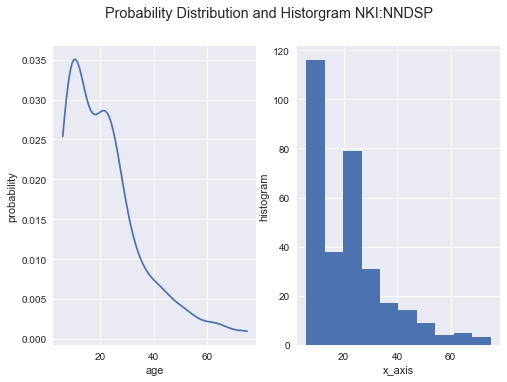

stats:  Ks_2sampResult(statistic=0.056462358427714854, pvalue=0.59053597735808294)


In [23]:
df_nki_nndsp = sample(df_nki, df_nndsp, title_to='NKI', title_from='NNDSP')

## Sample CoRR:NNDSP

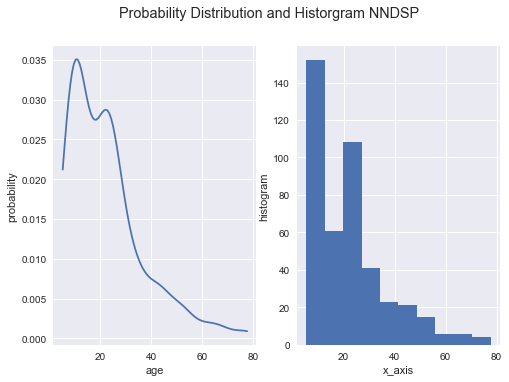

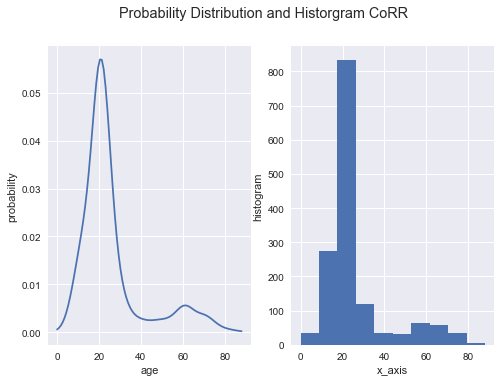

New Length:  187  with Precision:  1.0
Actual Length:  172
                               subj_paths  subject  Unnamed: 0  age SEX
3399  /data/DSST/CoRR/fs_corr/sub-0025175    25175         465    8   1
2221  /data/DSST/CoRR/fs_corr/sub-0026031    26031          39    8   2
5019  /data/DSST/CoRR/fs_corr/sub-0025105    25105         325    7   1
5365  /data/DSST/CoRR/fs_corr/sub-0025088    25088         291    8   1
1348  /data/DSST/CoRR/fs_corr/sub-0025019    25019          71    8   1


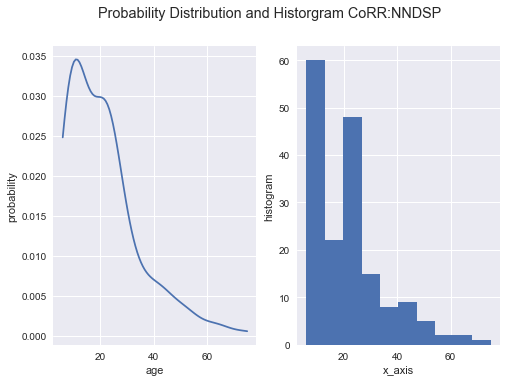

stats:  Ks_2sampResult(statistic=0.070046830929700432, pvalue=0.56495739740945705)


In [26]:
df_corr_nndsp = sample(df_corr, df_nndsp, title_to='CoRR', title_from='NNDSP', bucket_size=3)

## Sample SALD:NNDSP

## Sample NKI:HCP

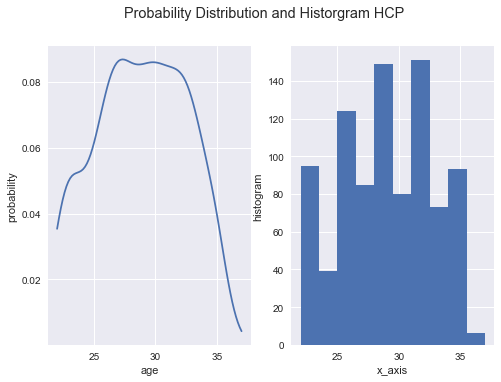

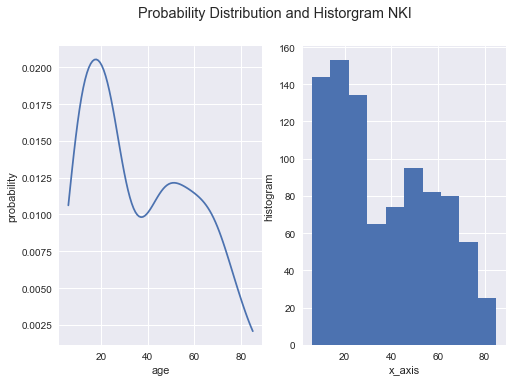

New Length:  94  with Precision:  1.0
Actual Length:  89
                                             subj_paths    subject   age  \
150   /data/NNDSP/derivatives/fs_nki_subj/sub-A00044131  A00044131  22.0   
586   /data/NNDSP/derivatives/fs_nki_subj/sub-A00028352  A00028352  23.0   
1047  /data/NNDSP/derivatives/fs_nki_subj/sub-A00072203  A00072203  23.0   
976   /data/NNDSP/derivatives/fs_nki_subj/sub-A00073600  A00073600  22.0   
420   /data/NNDSP/derivatives/fs_nki_subj/sub-A00058...  A00058667  23.0   

         sex handedness  
150     MALE      RIGHT  
586   FEMALE      RIGHT  
1047  FEMALE      RIGHT  
976   FEMALE      RIGHT  
420   FEMALE      RIGHT  


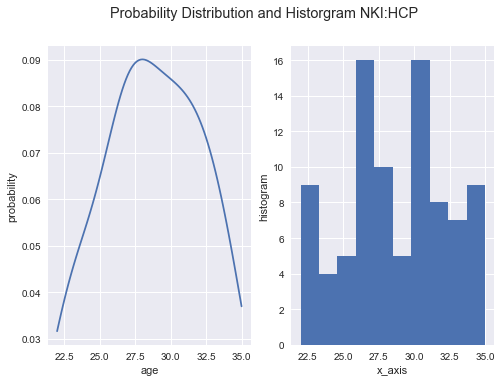

stats:  Ks_2sampResult(statistic=0.029577553198167073, pvalue=0.99999958360293306)


In [27]:
df_nki_hcp = sample(df_nki, df_hcp, title_to='NKI', title_from='HCP', bucket_size=2)

## Sample CoRR:HCP

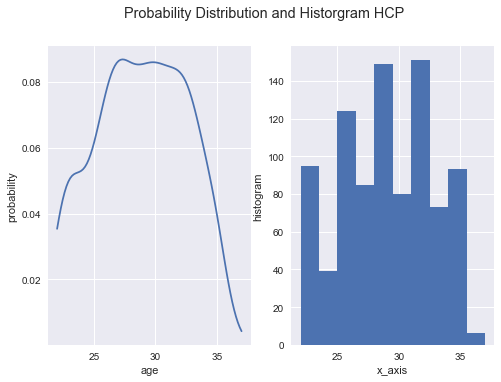

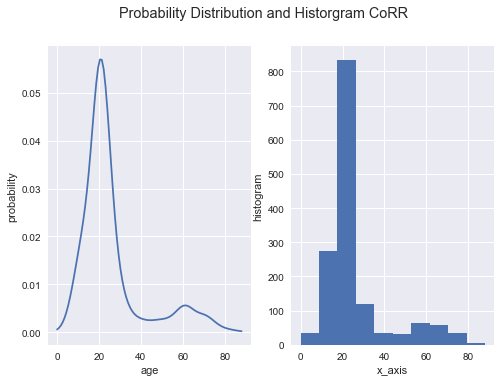

New Length:  97  with Precision:  1.0
Actual Length:  94
                               subj_paths  subject  Unnamed: 0  age SEX
370   /data/DSST/CoRR/fs_corr/sub-0025634    25634          10   23   1
3914  /data/DSST/CoRR/fs_corr/sub-0027201    27201          50   21   1
5066  /data/DSST/CoRR/fs_corr/sub-0027183    27183          14   23   2
5362  /data/DSST/CoRR/fs_corr/sub-0003002     3002           2   23   1
2636  /data/DSST/CoRR/fs_corr/sub-0025163    25163         441   21   2


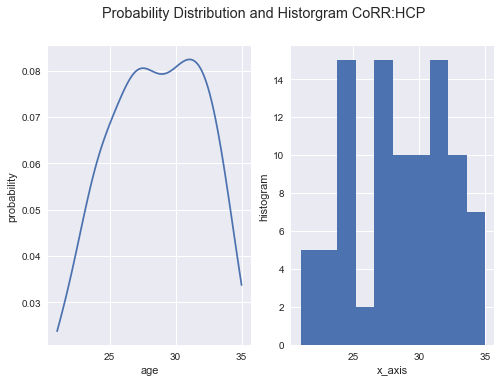

stats:  Ks_2sampResult(statistic=0.063568287174610716, pvalue=0.8712431094923726)


In [28]:
df_corr_hcp = sample(df_corr, df_hcp, title_to='CoRR', title_from='HCP', bucket_size=3)

## Sample SALD:HCP

In [56]:
%run /data/NNDSP/anal/analysis_notebooks/follow_up_analysis/util_models.ipynb

## Train NNDSP

In [30]:
scores_nndsp, nndsp_complex_train, nndsp_complex_test, nndsp_complex_pipe = complex_model(df_nndsp, nndsp_bar_dir)

Complex Source 431
Mean Absolute Error (Train, thickness): 0.0988572875336
Mean Absolute Error (Test, thickness): 6.10117670607
Complex Source 431


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error (Train, aseg): 3.72113345729
Mean Absolute Error (Test, aseg): 5.51001771875
Complex Source 431


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error (Train, area): 0.0995830174265
Mean Absolute Error (Test, area): 7.53505518245
Fitting stacking model
best max_depth: 4
Mean Absolute Error (Train): 2.83834208568
Mean Absolute Error (Test): 4.0101814638
                     r2     rpear    rpear2       mae     medae
aseg           0.721316  0.870219  0.757282  5.510018  3.340887
ct             0.700864  0.841493  0.708110  6.101177  4.602453
ca             0.554499  0.747972  0.559462  7.535055  5.663140
mean_pred      0.735203  0.887451  0.787570  5.292002  3.520173
pred_age_test  0.860765  0.929798  0.864524  4.010181  2.716941


In [57]:
nndsp_simple_train, nndsp_simple_test, nndsp_simple_pipe = simple_model(df_nndsp, nndsp_bar_dir, 
                                                                        model=True, 
                                                                        model_train = nndsp_complex_train, 
                                                                        model_test=nndsp_complex_test)

   subject                                   subj_paths      MRN  \
0      102  /data/NNDSP/derivatives/fs5.3_subj/sub-0102  4569829   
1      114  /data/NNDSP/derivatives/fs5.3_subj/sub-0114  4578673   
2      126  /data/NNDSP/derivatives/fs5.3_subj/sub-0126  4572324   
3      127  /data/NNDSP/derivatives/fs5.3_subj/sub-0127  4572166   
4      133  /data/NNDSP/derivatives/fs5.3_subj/sub-0133  4601373   

   nuclear_fam_id     Sex        age  Intra_Cran_Vol   WM_Frac   GM_Frac  \
0           10392    Male  28.542094    1.581414e+06  0.325566  0.039989   
1           10391    Male  25.957563    1.607836e+06  0.334801  0.041092   
2           10381    Male   6.015058    1.373947e+06  0.295549  0.041849   
3           10381    Male   7.926078    1.497001e+06  0.289696  0.039456   
4           10208  Female  22.168378    1.435193e+06  0.302876  0.040307   

   CSF_Frac  
0  0.010659  
1  0.012042  
2  0.007700  
3  0.008569  
4  0.014680  
Mean Absolute Error (Train): 6.19606717515
Mean Ab